# Mel Frequency Cepstral Coefficients

In [47]:
# Import Libraries
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

In [48]:
sample_rate, signal = scipy.io.wavfile.read('5_jackson_1.wav')

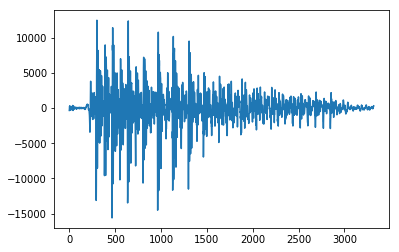

In [49]:
import matplotlib.pyplot as plt
plt.plot(signal)
plt.show()

In [5]:
# Pre-emphasis to ephasize higher frequencies
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [6]:
# Define framing constants
frame_size = 0.025 
frame_stride = 0.01

In [7]:
# Framing
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [8]:
frames *= numpy.hamming(frame_length)

In [9]:
# FFT
NFFT = 512  # 512 point FFT
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

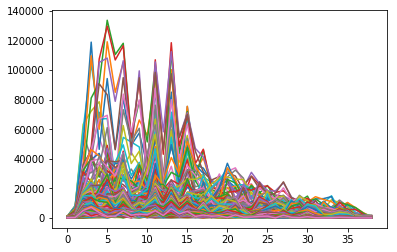

In [10]:
plt.plot(mag_frames)
plt.show()

In [11]:
# Filter banks
nfilt = 40

In [12]:
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

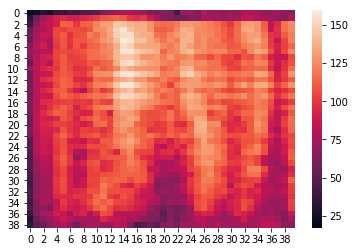

In [13]:
import seaborn as sns
sns.heatmap(filter_banks)
plt.show()

In [14]:
# MFCC
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [15]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

In [16]:
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

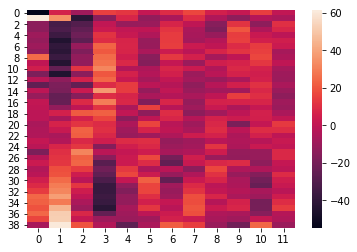

In [50]:
sns.heatmap(mfcc)

In [71]:
def mfcc(filename):
    sample_rate, signal = scipy.io.wavfile.read(filename)
    pre_emphasis = 0.97
    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025 
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]
    
    frames *= numpy.hamming(frame_length)
    # FFT
    NFFT = 512  # 512 point FFT
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    # Filter banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB
    # MFCC
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [72]:
jack1 = mfcc('5_jackson_1.wav')

In [77]:
jack2 = mfcc('5_jackson_4.wav')

In [78]:
print(numpy.shape(jack1))
print(numpy.shape(jack2))

(39, 12)
(51, 12)


In [79]:
def mse(a, b):
    return (numpy.sum((a - b)**2))

In [80]:
mse(jack1,jack2)

ValueError: operands could not be broadcast together with shapes (39,12) (51,12) 